In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.estela import Predictor
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.climate_emulator import Plot_Simulation
from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')




In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])


In [4]:
# TODO: complete historical waves data (AWL, TWL, SS???) PUEDE QUE AL NOTEBOOK WAVES


## Climate Emulator - Fitting

In [5]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)

# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}

#CE.FitExtremes(DWTs_fit, WVS_fit, config)

# Load Climate Emulator
CE.Load()

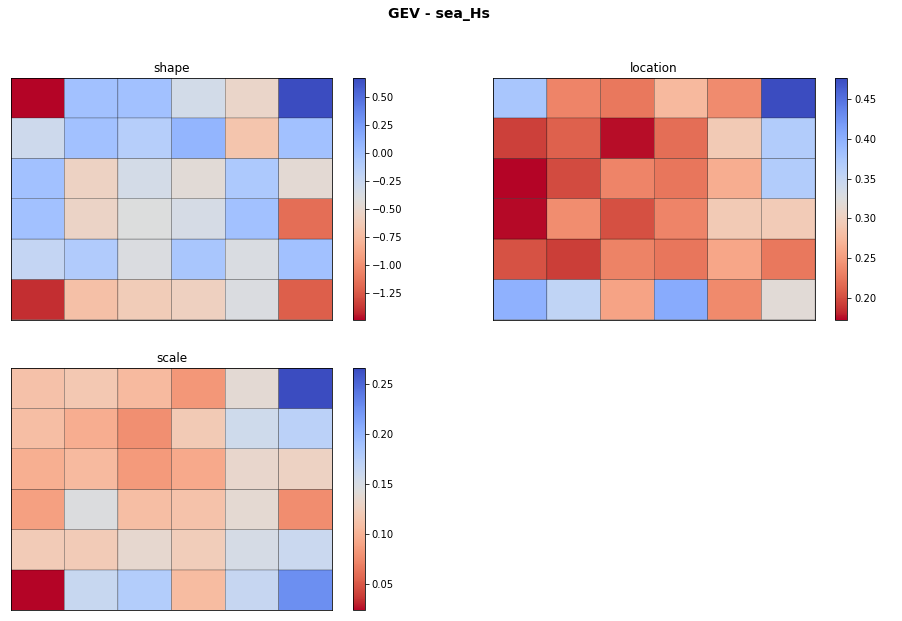

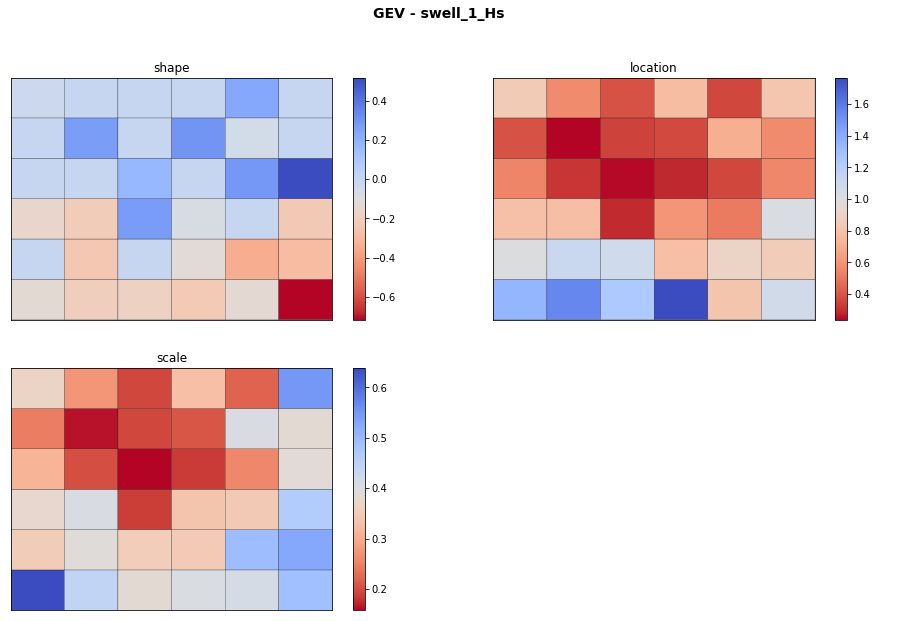

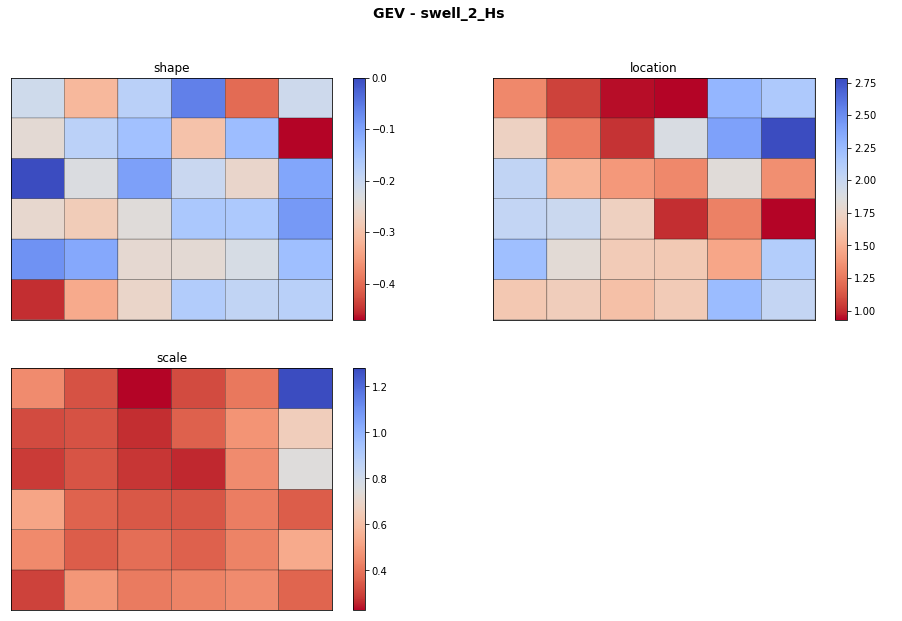

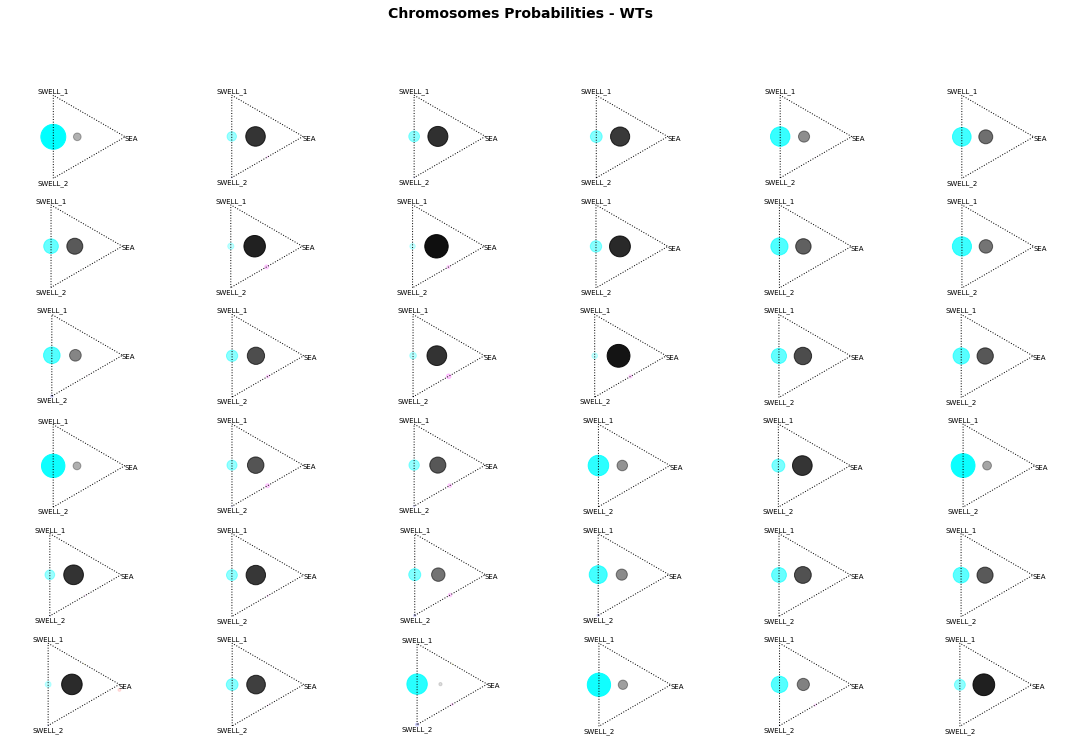

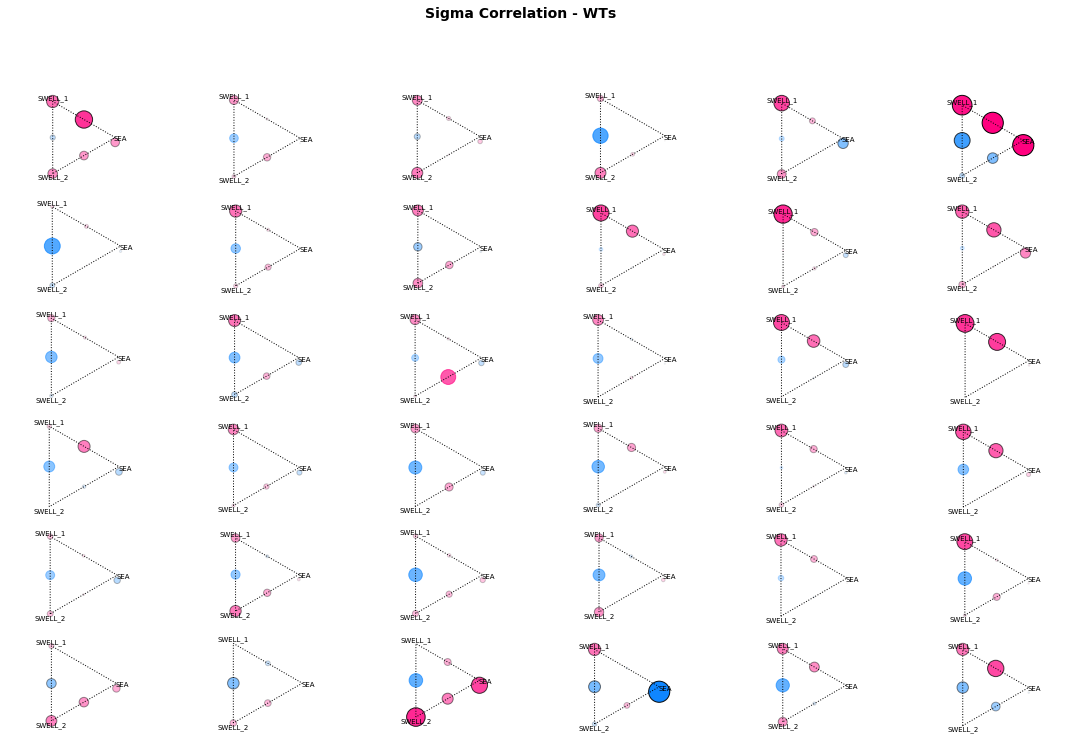

In [6]:
# Fit report figures
CE.Report_Fit();



## Climate Emulator - Simulation

In [7]:
# Select DWT series to simulate
DWTs_sim = DWTs_sim.sel(time=slice('1700-01-01','2700-01-01'), n_sim=0)

print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (time: 365243)
Coordinates:
  * time         (time) object 1700-01-01 00:00:00 ... 2700-01-01 00:00:00
Data variables:
    evbmus_sims  (time) float32 ...


In [8]:
# --------------------------------------
#  Climate Emulator simulation

#ce_sims = 10

# Simulate waves
#WVS_sim = CE.Simulate_Waves(DWTs_sim, ce_sims, filters={'hs':True, 'tp':True, 'ws':True})

# Simulate TCs and update simulated waves
#TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)


# Load Climate Emulator Simulations
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim()


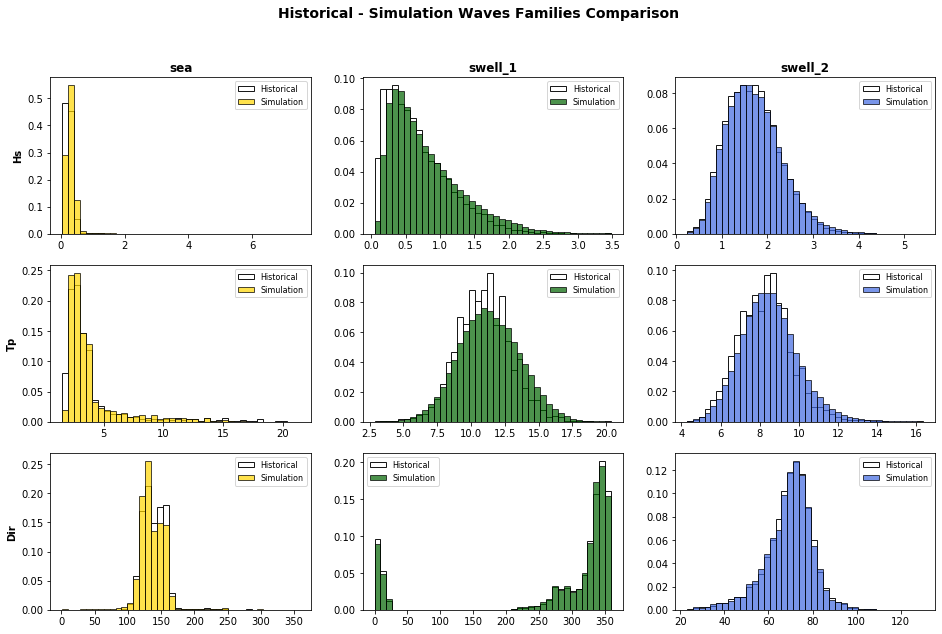

In [9]:
# Plot simulated waves parameters distribution 

Plot_Waves_Histogram_FitSim(WVS_fit, WVS_upd.isel(n_sim=0));
    

In [10]:
# --------------------------------------
#  Generate hourly waves data from storms 

def Simulation_Hourly(wvs_sim, tcs_sim):
    '''
    Generate hourly simulation output. 
    
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - calculates AWL
    '''
    
    # iterate simulations
    ls_hy = []
    for i_sim in wvs_sim.n_sim:
        
        # Aggregate waves families
        wvs_agr = Aggregate_WavesFamilies(wvs_sim.sel(n_sim=i_sim))

        # Calculate Intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, tcs_sim.sel(n_sim=i_sim))
        ls_hy.append(hy)
        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)

    return hy
    
    
# Generate simulated hourly data
#SIM_WAVES_h = Simulation_Hourly(WVS_upd, TCs_sim)  
    
# Store complete simulations
#db.Save_SIM_Waves(SIM_WAVES_h)


# Load simulated waves
SIM_WAVES_h = db.Load_SIM_Waves()

print(SIM_WAVES_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765809)
Coordinates:
  * time     (time) object 1700-01-01 00:00:00 ... 2700-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float32 ...
    Tp       (n_sim, time) float32 ...
    Dir      (n_sim, time) float32 ...
    SS       (n_sim, time) float32 ...
    AWL      (n_sim, time) float32 ...


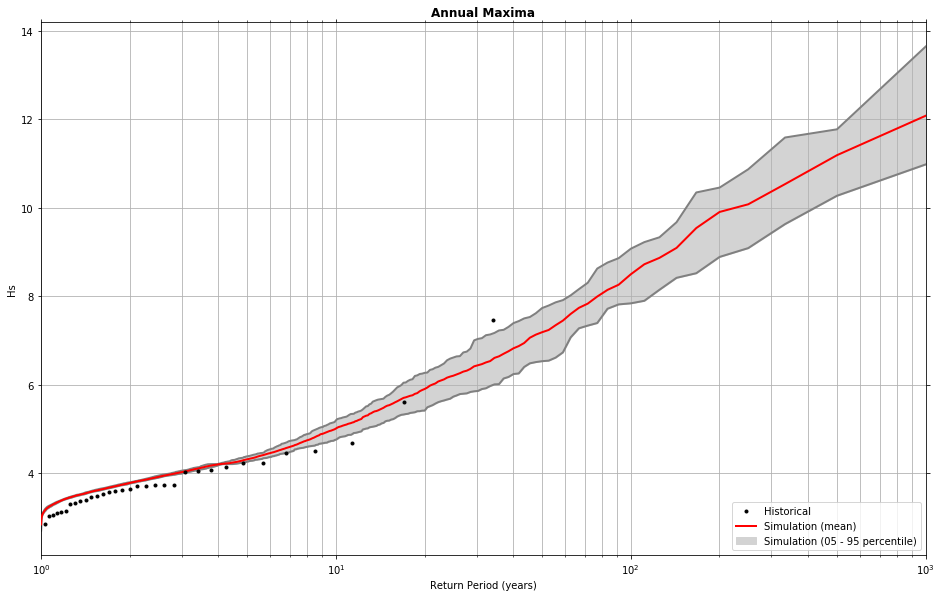

In [11]:
# --------------------------------------
#  Annual Maxima 
var_name = 'Hs'

# historical annual maxima
hist_A = CE.WVS_MS[var_name].groupby('time.year').max(dim='time')

# simulation annual maxima 
sim_A = SIM_WAVES_h[var_name].groupby('time.year').max(dim='time')

# Plot Return Period graph
Plot_ReturnPeriodValidation(hist_A, sim_A);

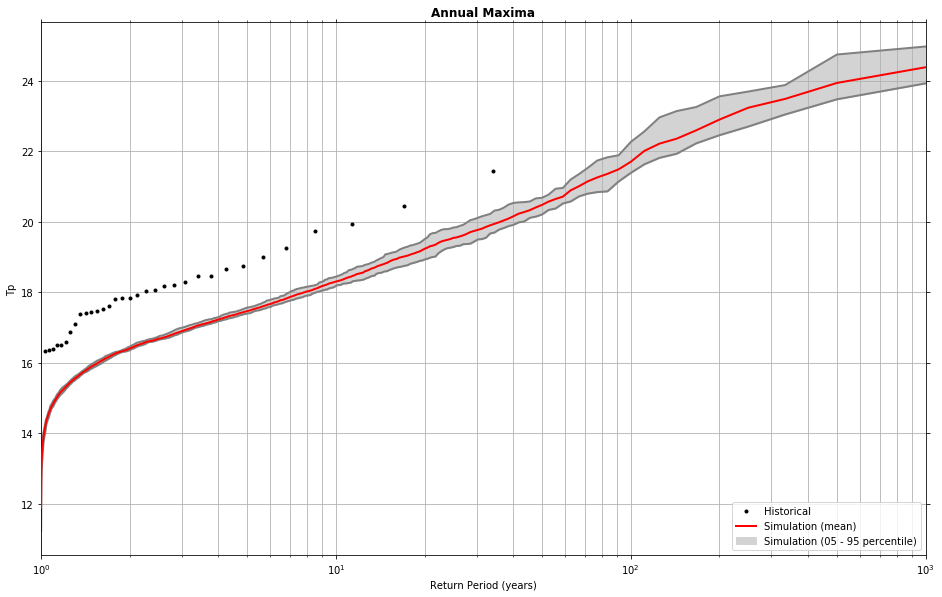

In [12]:
# --------------------------------------
#  Annual Maxima 
var_name = 'Tp'

# historical annual maxima
hist_A = CE.WVS_MS[var_name].groupby('time.year').max(dim='time')

# simulation annual maxima 
sim_A = SIM_WAVES_h[var_name].groupby('time.year').max(dim='time')

# Plot Return Period graph
Plot_ReturnPeriodValidation(hist_A, sim_A);

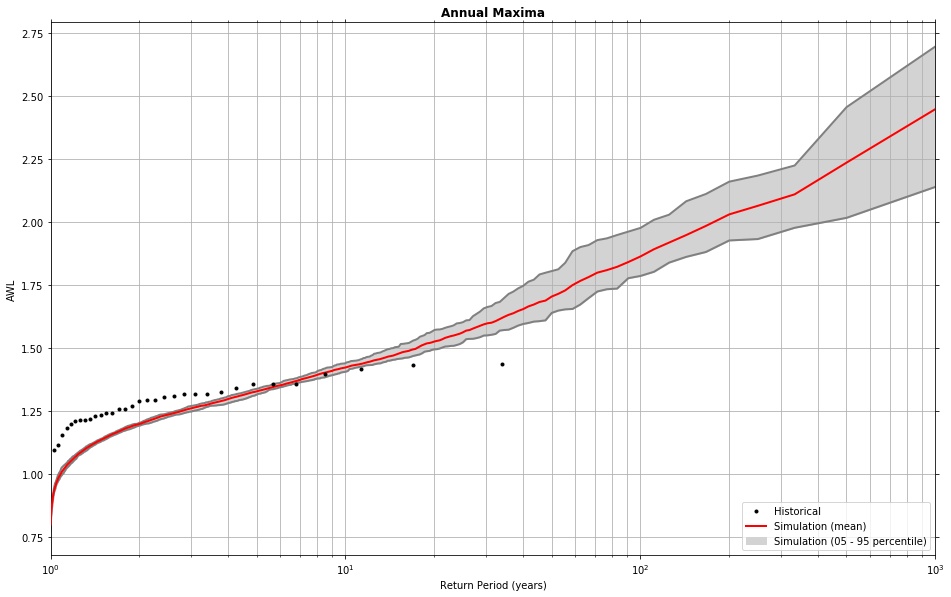

In [13]:
# --------------------------------------
#  Annual Maxima 
var_name = 'AWL'

# historical annual maxima
hist_A = CE.WVS_MS[var_name].groupby('time.year').max(dim='time')

# simulation annual maxima 
sim_A = SIM_WAVES_h[var_name].groupby('time.year').max(dim='time')

# Plot Return Period graph
Plot_ReturnPeriodValidation(hist_A, sim_A);


## Climate Emulator - Complete Output

In [ ]:
# --------------------------------------
# Get all simulated data (hourly): AWTs, DWTs, MJO, MMSL, AT

SIM_COVARS_h = db.Load_SIM_Covariates(n_sim_awt=0, n_sim_mjo=0, n_sim_dwt=0, regenerate=True)
print(SIM_COVARS_h)

# Complete simulation output 
d1, d2 = xds_limit_dates([SIM_WAVES_h, SIM_COVARS_h])
SIM_WAVES_h = SIM_WAVES_h.sel(time = slice(d1, d2))
SIM_COVARS_h = SIM_COVARS_h.sel(time = slice(d1, d2))
SIM_COMPLETE = xr.merge([SIM_WAVES_h, SIM_COVARS_h])

# Store complete simulations
db.Save_SIM_Complete(SIM_COMPLETE)


In [ ]:
# Plot simulated output
#SIM = db.Load_SIM_Complete()
print(SIM)


Plot_Simulation(SIM.sel(n_sim=0));
